# Group 3 - Assigment 3

In [1]:
import pandas as pd
import networkx as nx
import nxviz as nv
from pandasql import sqldf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#work file
data = pd.read_csv("data/soc-redditHyperlinks-title.tsv", sep='\t')
data.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,rddtgaming,rddtrust,1u4pzzs,2013-12-31 16:39:18,1,"25.0,23.0,0.76,0.0,0.44,0.12,0.12,4.0,4.0,0.0,..."
1,xboxone,battlefield_4,1u4tmfs,2013-12-31 17:59:11,1,"100.0,88.0,0.78,0.02,0.08,0.13,0.07,16.0,16.0,..."
2,ps4,battlefield_4,1u4tmos,2013-12-31 17:59:40,1,"100.0,88.0,0.78,0.02,0.08,0.13,0.07,16.0,16.0,..."
3,fitnesscirclejerk,leangains,1u50xfs,2013-12-31 19:01:56,1,"49.0,43.0,0.775510204082,0.0,0.265306122449,0...."
4,fitnesscirclejerk,lifeprotips,1u51nps,2013-12-31 21:02:28,1,"14.0,14.0,0.785714285714,0.0,0.428571428571,0...."


In [3]:
data_props = data[['LINK_SENTIMENT','PROPERTIES']][0:10000]
words = []
for index, row in data_props.iterrows():
    word = row['PROPERTIES'].split(',')[7]
    words.append(word)
words = pd.DataFrame(words)
data_props['WORDS'] = words
data_props_w = data_props[['LINK_SENTIMENT','WORDS']]

In [4]:
data_props_w.head()

,LINK_SENTIMENT,WORDS
0,1,4.0
1,1,16.0
2,1,16.0
3,1,8.0
4,1,2.0


In [5]:
dist_n = sqldf("select count(LINK_SENTIMENT) as LS, WORDS from data_props_w where LINK_SENTIMENT<1 group by WORDS order by WORDS asc")
dist_n.head()

,LS,WORDS
0,27,10.0
1,33,11.0
2,37,12.0
3,27,13.0
4,35,14.0


In [6]:
dist_p = sqldf("select count(LINK_SENTIMENT) as LS, WORDS from data_props_w where LINK_SENTIMENT>0 group by WORDS order by WORDS")
dist_p.head()

,LS,WORDS
0,2,1.0
1,587,10.0
2,542,11.0
3,563,12.0
4,499,13.0


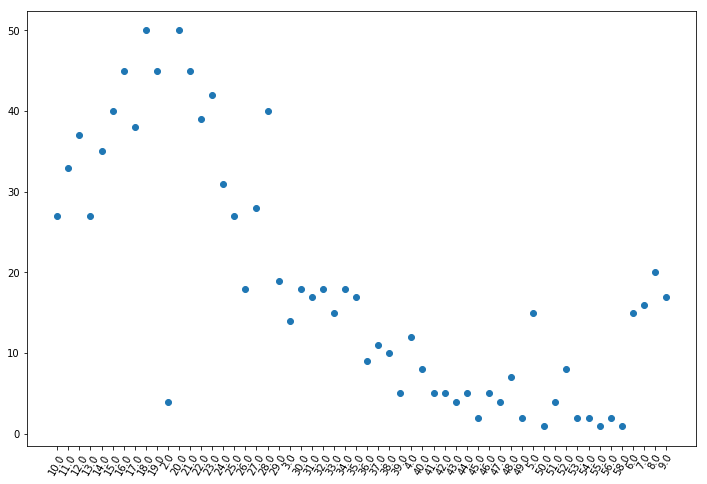

In [7]:
plt.figure(figsize=(12,8))
plt.xticks(rotation=60)
plt.scatter(dist_n.WORDS,dist_n.LS)

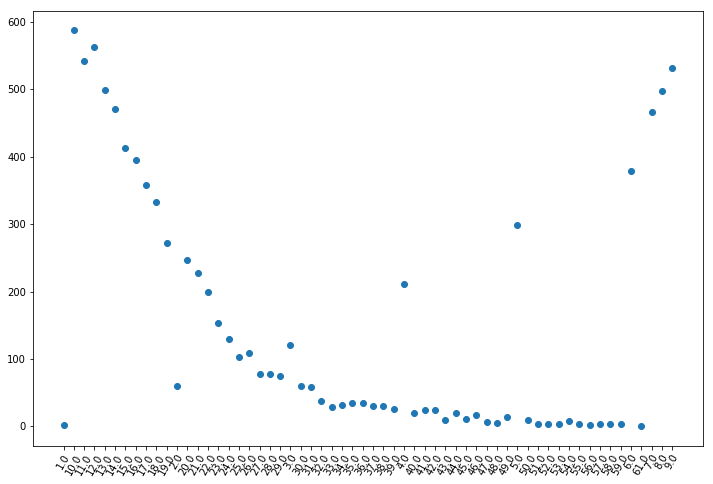

In [8]:
plt.figure(figsize=(12,8))
plt.xticks(rotation=60)
plt.scatter(dist_p.WORDS,dist_p.LS)

In [9]:
data.shape

(571927, 6)

In [10]:
data.dtypes

SOURCE_SUBREDDIT    object
TARGET_SUBREDDIT    object
POST_ID             object
TIMESTAMP           object
LINK_SENTIMENT       int64
PROPERTIES          object
dtype: object

In [11]:
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'], format="%Y-%m-%d %H:%M:%S")
data.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,rddtgaming,rddtrust,1u4pzzs,2013-12-31 16:39:18,1,"25.0,23.0,0.76,0.0,0.44,0.12,0.12,4.0,4.0,0.0,..."
1,xboxone,battlefield_4,1u4tmfs,2013-12-31 17:59:11,1,"100.0,88.0,0.78,0.02,0.08,0.13,0.07,16.0,16.0,..."
2,ps4,battlefield_4,1u4tmos,2013-12-31 17:59:40,1,"100.0,88.0,0.78,0.02,0.08,0.13,0.07,16.0,16.0,..."
3,fitnesscirclejerk,leangains,1u50xfs,2013-12-31 19:01:56,1,"49.0,43.0,0.775510204082,0.0,0.265306122449,0...."
4,fitnesscirclejerk,lifeprotips,1u51nps,2013-12-31 21:02:28,1,"14.0,14.0,0.785714285714,0.0,0.428571428571,0...."


In [12]:
data.isnull().any()

SOURCE_SUBREDDIT    False
TARGET_SUBREDDIT    False
POST_ID             False
TIMESTAMP           False
LINK_SENTIMENT      False
PROPERTIES          False
dtype: bool

In [13]:
data.columns

Index(['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT', 'POST_ID', 'TIMESTAMP',
       'LINK_SENTIMENT', 'PROPERTIES'],
      dtype='object')

In [14]:
uniqueSource = data['SOURCE_SUBREDDIT'].unique()
uniqueSource.size

43695

In [15]:
uniqueTarget = data['TARGET_SUBREDDIT'].unique()
uniqueTarget.size

26888

### Grouping all SUBREDDITS by SOURCE AND TARGET WITH SENTIMENT COUNT

In [16]:
data_group_neg = sqldf("select SOURCE_SUBREDDIT,TARGET_SUBREDDIT, sum(LINK_SENTIMENT) as NEG_SENT from data where LINK_SENTIMENT<1 group by SOURCE_SUBREDDIT,TARGET_SUBREDDIT order by NEG_SENT")
data_group_neg.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,NEG_SENT
0,shitredditsays,twoxchromosomes,-107
1,evenwithcontext,askreddit,-97
2,amrsucks,againstmensrights,-89
3,subredditdrama,relationships,-84
4,subredditdrama,askreddit,-81


In [17]:
len(data_group_neg)

29257

In [18]:
data_group_pos = sqldf("select SOURCE_SUBREDDIT,TARGET_SUBREDDIT, sum(LINK_SENTIMENT) as POS_SENT from data where LINK_SENTIMENT=1 group by SOURCE_SUBREDDIT,TARGET_SUBREDDIT order by POS_SENT desc")
data_group_pos.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POS_SENT
0,moronicmondayandroid,android,478
1,goodshibe,dogecoin,299
2,nightlypick,hockey,295
3,titlegore,todayilearned,279
4,switcharoo,pics,245


In [19]:
len(data_group_pos)

221593

In [20]:
data_group = pd.merge(data_group_neg, data_group_pos,  how='right', left_on=['SOURCE_SUBREDDIT','TARGET_SUBREDDIT'], right_on = ['SOURCE_SUBREDDIT','TARGET_SUBREDDIT'])
data_group['NEG_SENT'].fillna(0,inplace=True)
data_group['POS_SENT'].fillna(0,inplace=True)
data_group["TOTAL_SENT"]=data_group.POS_SENT-data_group.NEG_SENT
data_group.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,NEG_SENT,POS_SENT,TOTAL_SENT
0,shitredditsays,twoxchromosomes,-107.0,118,225.0
1,evenwithcontext,askreddit,-97.0,190,287.0
2,amrsucks,againstmensrights,-89.0,91,180.0
3,subredditdrama,relationships,-84.0,100,184.0
4,subredditdrama,askreddit,-81.0,130,211.0


In [21]:
len(data_group)

221593

In [22]:
len(data_group[data_group.TOTAL_SENT<10])

213825

In [23]:
sample_data = data_group[data_group.TOTAL_SENT>=10]
print ("After removing SUBREDITS with a repetition of 10: Remaining Connections = "+str(len(sample_data)))

After removing SUBREDITS with a repetition of 10: Remaining Connections = 7768


In [24]:
sample_data.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,NEG_SENT,POS_SENT,TOTAL_SENT
0,shitredditsays,twoxchromosomes,-107.0,118,225.0
1,evenwithcontext,askreddit,-97.0,190,287.0
2,amrsucks,againstmensrights,-89.0,91,180.0
3,subredditdrama,relationships,-84.0,100,184.0
4,subredditdrama,askreddit,-81.0,130,211.0


In [25]:
nodes = pd.unique(sample_data[['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT']].values.ravel('K'))
len(nodes)

3375

In [26]:
G=nx.DiGraph()
G=nx.from_pandas_edgelist(sample_data, 'SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT', edge_attr='TOTAL_SENT')  

In [27]:
len(G.edges)

7328

In [28]:
len(G.nodes)

3375

In [29]:
#Most noisy using degree of centrality
deg_cent = nx.degree_centrality(G)
max_dc = max(deg_cent.values())
prolific_collaborators = [n for n, dc in deg_cent.items() if dc ==max_dc]
prolific_collaborators

['subredditdrama']

In [ ]:
tempneg = sqldf("select strftime('%Y',TIMESTAMP) as Year, count(LINK_SENTIMENT) as LINK_SENTIMENT from data where SOURCE_SUBREDDIT='"+prolific_collaborators[0]+"' and LINK_SENTIMENT<0 group by Year")
temppos = sqldf("select strftime('%Y',TIMESTAMP) as Year, count(LINK_SENTIMENT) as LINK_SENTIMENT from data where SOURCE_SUBREDDIT='"+prolific_collaborators[0]+"' and LINK_SENTIMENT>0 group by Year")

In [ ]:
plt.plot(tempneg.Year,tempneg.LINK_SENTIMENT, label="negative")
plt.plot(temppos.Year,temppos.LINK_SENTIMENT, label="positive")
plt.title("LINK SENTIMENT BY "+str(prolific_collaborators[0])+" Over Years")
plt.xlabel("Year")
plt.ylabel("Negative Link Sentiments")
plt.legend()

In [ ]:
temppos = sqldf("select strftime('%Y',TIMESTAMP) as Year, TARGET_SUBREDDIT, sum(LINK_SENTIMENT) as LINK_SENTIMENT from data where SOURCE_SUBREDDIT='"+prolific_collaborators[0]+"' and Year='2015' and LINK_SENTIMENT<0 group by TARGET_SUBREDDIT order by LINK_SENTIMENT")
temppos.head()

In [ ]:
temppos = sqldf("select strftime('%Y',TIMESTAMP) as Year, SOURCE_SUBREDDIT, sum(LINK_SENTIMENT) as LINK_SENTIMENT from data where TARGET_SUBREDDIT='relationships' and Year='2015' and LINK_SENTIMENT<0 group by SOURCE_SUBREDDIT order by LINK_SENTIMENT")

In [ ]:
temppos.head()

In [ ]:
dataY = sqldf("select SOURCE_SUBREDDIT,TARGET_SUBREDDIT, count(LINK_SENTIMENT) as LINK_SENTIMENT from data where (TARGET_SUBREDDIT like 'relationships') group by SOURCE_SUBREDDIT order by LINK_SENTIMENT desc")

In [ ]:
X = nx.DiGraph()
dataX = dataY[(dataY.SOURCE_SUBREDDIT=='relationships') | (dataY.TARGET_SUBREDDIT=='relationships')][0:100]
X=nx.from_pandas_edgelist(dataX, 'SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT')
nx.draw(X)

In [ ]:
temppos = sqldf("select strftime('%Y',TIMESTAMP) as Year, SOURCE_SUBREDDIT, sum(LINK_SENTIMENT) as LINK_SENTIMENT from data where TARGET_SUBREDDIT='relationships' and Year='2015' and LINK_SENTIMENT>0 group by SOURCE_SUBREDDIT order by LINK_SENTIMENT desc")

In [ ]:
temppos.head()

In [ ]:
neg_leader = sqldf("select SOURCE_SUBREDDIT, sum(NEG_SENT) as NEG_SENT from sample_data group by SOURCE_SUBREDDIT order by NEG_SENT")
neg_leader.head()

In [ ]:
neg_leader = neg_leader[0:100]

In [ ]:
srd = G.subgraph(neg_leader.SOURCE_SUBREDDIT)
for n, d in srd.nodes(data=True):
    # Calculate the degree of each node: G.node[n]['degree']
    srd.node[n]['degree'] = nx.degree(srd, n)

In [ ]:
t = nv.ArcPlot(graph=srd, node_order='degree', node_label=True)
t.draw()
plt.title("Interractions between the top 100 negative Subreddits")
plt.show()

In [ ]:
neg_leader = sqldf("select SOURCE_SUBREDDIT, sum(POS_SENT) as POS_SENT from sample_data group by SOURCE_SUBREDDIT order by POS_SENT desc")
neg_leader.head()

In [ ]:
neg_leader = neg_leader[0:100]
srd = G.subgraph(neg_leader.SOURCE_SUBREDDIT)
for n, d in srd.nodes(data=True):
    # Calculate the degree of each node: G.node[n]['degree']
    srd.node[n]['degree'] = nx.degree(srd, n)

In [ ]:
t = nv.MatrixPlot(graph=srd, node_order='degree', node_color='degree')
t.draw()
plt.title("Interractions between the top 100 negative Subreddits")
plt.show()

In [ ]:
def largest_closed_community(G,size):
    mcs = []
    for clique in nx.find_cliques(G):
        if len(clique)==size:
            mcs.append(clique)
    return mcs 

size_of_cliques = range(3,22)
num_of_cliques = []
for n in size_of_cliques:
    size = len(largest_closed_community(G,n))
    if (size!=0):
        num_of_cliques.append(size)

In [ ]:
size_of_cliques = range(3,len(num_of_cliques)+3)
size_of_cliques=list(size_of_cliques)
plt.bar(size_of_cliques,num_of_cliques)
plt.title("Distribution of fully connected communities")
plt.xlabel("Nodes in Subgraph")
plt.ylabel("Number of Subgraphs")

In [ ]:
large_c = largest_closed_community(G,max(size_of_cliques))
node_list = []
for _edge in large_c:
    for _node in _edge:
        if _node not in node_list:
            node_list.append(_node)
sub_G=G.subgraph(node_list) 
sub_G.nodes

In [ ]:
c = nv.CircosPlot(sub_G,node_labels=True)
# Draw the CircosPlot to the screen
c.draw()
plt.title("Interractions between the largest community")
plt.show()


In [ ]:
nx.draw(sub_G,with_labels = True)
plt.title("Interractions between the largest community")
plt.show()

### Top 5 target subreddit

In [ ]:
top5Target = data.groupby('TARGET_SUBREDDIT')['POST_ID'].count().reset_index(name='count').sort_values(by='count',ascending=False).head(5)
top5Target

In [ ]:
towardPositive = data[data.LINK_SENTIMENT==1]
towardNegative = data[data.LINK_SENTIMENT==-1]
print("Source to positve target: ", towardPositive.shape)
print("Source to negative target: ", towardNegative.shape)
print("Negative % = ", towardNegative.shape[0]*100/(towardPositive.shape[0] + towardNegative.shape[0]))
sns.countplot(x='LINK_SENTIMENT', data=data)

### Convert the data into graph model 
- vertex: subreddits
- edge: source and target subreddits

### Find clustering coefficient(global/local)
- Adjacency list
- Sort-Merge algorithm to find triangles and triads

### Find strongly connected components (similar subreddit)
- When there is a loop among all the nodes in a component
- Show the subreddits of same cluster

### Finding K-Core
- How sparse the graph is?

### Analysis of subreddit based on time
- When did this subreddit(i.e. askreddit) become popular?

### Is there any relationship between source and target subreddit when the LINK_SENTIMENT is negative?